# TCC - Treinamento de Redes Neurais Convolucionais (CNN)

#### 1. Setup, Customização do Dataset (Treino com Validação e Teste) + DataLoaders

In [2]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# configuracoes do ambiente e hardware
DATASET_ROOT = "dataset"

# hiperparametros considerando rtx 4070 com 12gb de VRAM
BATCH_SIZE = 128 # alto throughput com gpu de 12gb
IMG_SIZE = 224 # resolucao padrao efficientnet, necessario upscaling de 128px para 224px
NUM_WORKERS = 0 # para evitar overhead de cpu no windows
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"Dispositivo ativo: {torch.cuda.get_device_name(0)}")
    print(f"VRAM total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} gb")
else:
    print("GPU nao detectada!")
    exit()

# carregamento do dataset
class AmazonChipsDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        print(f"Carregando conjunto: {split}")
        
        # varredura das pastas
        classes = ['sem_garimpo', 'com_garimpo']
        scanned = 0
        
        for label_idx, cls_name in enumerate(classes):
            cls_folder = os.path.join(root_dir, split, cls_name)
            if not os.path.exists(cls_folder): continue
            
            valid_exts = ('.png', '.jpg', '.jpeg', '.tif')
            files = [f for f in os.listdir(cls_folder) if f.lower().endswith(valid_exts)]
            
            for fname in files:
                scanned += 1
                fpath = os.path.join(cls_folder, fname)
                # adiciona imagem diretamente a lista
                self.samples.append((fpath, label_idx))
        
        print(f"Total carregado: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            img = Image.open(path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, label
        except Exception as e:
            print(f"Erro de leitura: {path}")
            return torch.zeros((3, IMG_SIZE, IMG_SIZE)), label

# Pipeline de transformacao

# treino: resize + augmentation para aumentar robustez
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # upscaling das imagens de 128px para 224px
    transforms.RandomHorizontalFlip(p=0.5), # espelhamento
    transforms.RandomVerticalFlip(p=0.5), # rotacao vertical
    transforms.RandomRotation(20), # pequenas rotacoes
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # mudanca na iluminacao
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalizacao para o padrao do ImageNet (transfer learning)
])

# validacao e teste: apenas resize e normalizacao
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# loaders
print("\nConfigurando dataloaders")

# dataset de treino base
full_train_ds = AmazonChipsDataset(DATASET_ROOT, split='train', transform=train_transforms)

# split do dataset de treino em treino (80%) e validacao (20%) 
# a validacao monitora overfitting durante as epocas (simulacao de teste)
train_len = int(0.8 * len(full_train_ds))
val_len = len(full_train_ds) - train_len
train_sub, val_sub = random_split(full_train_ds, [train_len, val_len])

# dataset de teste (mesmo utilizado no baseline)
test_ds = AmazonChipsDataset(DATASET_ROOT, split='test', transform=val_transforms)

# loaders otimizados
# "pin_memory=true" nos parametros acelera transferencia para vram
train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_sub,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"\nSetup concluido")
print(f"Treino: {len(train_sub)} imagens")
print(f"Validacao: {len(val_sub)} imagens")
print(f"Teste: {len(test_ds)} imagens")

Dispositivo ativo: NVIDIA GeForce RTX 4070
VRAM total: 12.88 gb

Configurando dataloaders
Carregando conjunto: train
Total carregado: 89266
Carregando conjunto: test
Total carregado: 22318

Setup concluido
Treino: 71412 imagens
Validacao: 17854 imagens
Teste: 22318 imagens


#### 2. Definição das Arquiteturas: Simples (Própria) x Transfer Learning (EfficientNet)

In [ ]:
import torch.nn as nn
from torchvision import models

# arquitetura 1: cnn simples (customizada)
# objetivo: baseline leve para provar eficacia da convolucao sobre metodos estatisticos
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # extrator de features com 3 blocos: conv, relu e pool
        self.features = nn.Sequential(
            # bloco 1: detecta bordas simples
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # bloco 2: formas geometricas
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # bloco 3: texturas complexas como garimpo
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # classificador
        # global avg pooling reduz parametros e evita overfitting em vez de flatten
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5), # regularizacao
            nn.Linear(64, 2) # saida binaria
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

# arquitetura 2: efficientnet-b0 (transfer learning)
# objetivo: estado da arte em eficiencia, usando pesos da imagenet
class TransferEfficientNet(nn.Module):
    def __init__(self, freeze_backbone=True):
        super(TransferEfficientNet, self).__init__()
        
        print("Carregando pesos ImageNet...")
        # carrega arquitetura otimizada
        self.base_model = models.efficientnet_b0(weights='DEFAULT')
        
        # congelamento das camadas convolucionais, aproveitando filtros treinados em milhoes de imagens
        if freeze_backbone:
            for param in self.base_model.features.parameters():
                param.requires_grad = False
            print("Backbone congelado (Feature Extractor)")
        
        # substitui cabeca de classificacao original (1000 classes -> 2 classes [com_garimpo, sem_garimpo])
        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features, 2)
        )

    def forward(self, x):
        return self.base_model(x)

# inicializa o modelo
def get_model(model_name, device):
    if model_name == 'simple':
        model = SimpleCNN()
    elif model_name == 'efficientnet':
        model = TransferEfficientNet()
    else:
        raise ValueError("Modelo desconhecido")
    
    return model.to(device)

# teste de funcionamento dos modelos (224 -> 2)
if __name__ == "__main__":
    print("\nTeste de instanciacao:")
    dummy = torch.randn(2, 3, 224, 224).to(DEVICE)
    
    # testa simple cnn
    model = get_model('simple', DEVICE)
    out = model(dummy)
    print(f"SimpleCNN Output: {out.shape} (Esperado: [2, 2])")
    
    # testa efficientnet
    model = get_model('efficientnet', DEVICE)
    out = model(dummy)
    print(f"EfficientNet Output: {out.shape} (Esperado: [2, 2])")


Teste de instanciacao:
SimpleCNN Output: torch.Size([2, 2]) (Esperado: [2, 2])
Carregando pesos ImageNet...
Backbone congelado (Feature Extractor)
EfficientNet Output: torch.Size([2, 2]) (Esperado: [2, 2])


#### 3. Motor de Treinamento e Validação das CNNs

In [ ]:
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm 

# configuracoes
NUM_EPOCHS = 50 
LEARNING_RATE = 0.001
PATIENCE = 5 

def train_model(model, train_loader, val_loader, device, model_name):
    since = time.time()
    
    print(f"\nIniciando: {model_name}")
    print(f"Device: {device}")
    print("-" * 40)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(NUM_EPOCHS):
        print(f'Epoca {epoch+1}/{NUM_EPOCHS}')
        
        # Cada epoca tem fase de treino e validacao
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            
            # TQDM
            pbar = tqdm(dataloader, desc=f"{phase.upper()}", leave=True)
            
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # estatisticas
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels.data)
                total_samples += batch_size
                
                # Mostra a Loss e Acc do batch atual
                epoch_acc_current = running_corrects.double() / total_samples
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}', 
                    'acc': f'{epoch_acc_current:.4f}'
                })
                
            # fim da fase
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples
            
            # salva historico
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                scheduler.step(epoch_loss)
                
                # check de melhor modelo
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
                    print(f"   !Modelo salvo! Melhor Loss: {best_loss:.4f}")
                else:
                    patience_counter += 1               
        print()
        
        if patience_counter >= PATIENCE:
            print(f"Early stopping na epoca {epoch+1}")
            break
            
    time_elapsed = time.time() - since
    print(f'Treino finalizado em {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Melhor Acc Val: {best_acc:.4f}')
    
    model.load_state_dict(best_model_wts)
    return model, history

if __name__ == "__main__":
    # Treinar SimpleCNN
    simple_model = get_model('simple', DEVICE)
    simple_model, simple_hist = train_model(
        simple_model, train_loader, val_loader, DEVICE, model_name="simple_cnn"
    )
    
    # Treinar EfficientNet
    eff_model = get_model('efficientnet', DEVICE)
    eff_model, eff_hist = train_model(
        eff_model, train_loader, val_loader, DEVICE, model_name="efficientnet_b0"
    )


Iniciando: simple_cnn
Device: cuda
----------------------------------------
Epoca 1/50


VAL: 100%|██████████| 140/140 [00:52<00:00,  2.67it/s, loss=0.6894, acc=0.6615]


   !Modelo salvo! Melhor Loss: 0.6168

Epoca 2/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.95it/s, loss=0.7123, acc=0.6672]


   !Modelo salvo! Melhor Loss: 0.6031

Epoca 3/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.95it/s, loss=0.6189, acc=0.6698]


   !Modelo salvo! Melhor Loss: 0.6019

Epoca 4/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.94it/s, loss=0.6214, acc=0.6847]


   !Modelo salvo! Melhor Loss: 0.5847

Epoca 5/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.95it/s, loss=0.6310, acc=0.6715]



Epoca 6/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.95it/s, loss=0.6948, acc=0.6803]



Epoca 7/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.94it/s, loss=0.6078, acc=0.6893]


   !Modelo salvo! Melhor Loss: 0.5681

Epoca 8/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.93it/s, loss=0.6082, acc=0.6956]


   !Modelo salvo! Melhor Loss: 0.5577

Epoca 9/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.93it/s, loss=0.6069, acc=0.7031]


   !Modelo salvo! Melhor Loss: 0.5554

Epoca 10/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.94it/s, loss=0.5875, acc=0.6998]



Epoca 11/50


VAL: 100%|██████████| 140/140 [00:50<00:00,  2.80it/s, loss=0.5733, acc=0.7052]


   !Modelo salvo! Melhor Loss: 0.5468

Epoca 12/50


VAL: 100%|██████████| 140/140 [00:46<00:00,  3.00it/s, loss=0.6155, acc=0.6997]



Epoca 13/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.95it/s, loss=0.5824, acc=0.6992]



Epoca 14/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.96it/s, loss=0.6449, acc=0.6825]



Epoca 15/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.90it/s, loss=0.5352, acc=0.7164]


   !Modelo salvo! Melhor Loss: 0.5324

Epoca 16/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.90it/s, loss=0.5785, acc=0.7159]



Epoca 17/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.88it/s, loss=0.5657, acc=0.7137]


   !Modelo salvo! Melhor Loss: 0.5321

Epoca 18/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.89it/s, loss=0.5292, acc=0.7143]


   !Modelo salvo! Melhor Loss: 0.5313

Epoca 19/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.89it/s, loss=0.5555, acc=0.7153]



Epoca 20/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.89it/s, loss=0.5625, acc=0.7152]


   !Modelo salvo! Melhor Loss: 0.5294

Epoca 21/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.89it/s, loss=0.5572, acc=0.7153]



Epoca 22/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.90it/s, loss=0.5303, acc=0.7140]



Epoca 23/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.90it/s, loss=0.5292, acc=0.7198]



Epoca 24/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.88it/s, loss=0.5594, acc=0.7183]


   !Modelo salvo! Melhor Loss: 0.5266

Epoca 25/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.89it/s, loss=0.5664, acc=0.7173]



Epoca 26/50


VAL: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.5353, acc=0.7218]



Epoca 27/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.89it/s, loss=0.5520, acc=0.7153]



Epoca 28/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.89it/s, loss=0.5444, acc=0.7180]



Epoca 29/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.89it/s, loss=0.5510, acc=0.7151]



Early stopping na epoca 29
Treino finalizado em 119m 13s
Melhor Acc Val: 0.7183
Carregando pesos ImageNet...
Backbone congelado (Feature Extractor)

Iniciando: efficientnet_b0
Device: cuda
----------------------------------------
Epoca 1/50


VAL: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.5759, acc=0.7267]


   !Modelo salvo! Melhor Loss: 0.5381

Epoca 2/50


VAL: 100%|██████████| 140/140 [00:50<00:00,  2.78it/s, loss=0.5695, acc=0.7253]


   !Modelo salvo! Melhor Loss: 0.5354

Epoca 3/50


VAL: 100%|██████████| 140/140 [00:49<00:00,  2.83it/s, loss=0.5621, acc=0.7227]



Epoca 4/50


VAL: 100%|██████████| 140/140 [00:49<00:00,  2.83it/s, loss=0.5708, acc=0.7248]



Epoca 5/50


VAL: 100%|██████████| 140/140 [00:49<00:00,  2.85it/s, loss=0.6194, acc=0.7271]


   !Modelo salvo! Melhor Loss: 0.5343

Epoca 6/50


VAL: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.6189, acc=0.7262]


   !Modelo salvo! Melhor Loss: 0.5338

Epoca 7/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.86it/s, loss=0.6181, acc=0.7204]



Epoca 8/50


VAL: 100%|██████████| 140/140 [00:49<00:00,  2.82it/s, loss=0.5473, acc=0.7228]



Epoca 9/50


VAL: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.5446, acc=0.7238]



Epoca 10/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.87it/s, loss=0.5812, acc=0.7278]


   !Modelo salvo! Melhor Loss: 0.5309

Epoca 11/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.87it/s, loss=0.5629, acc=0.7240]



Epoca 12/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.90it/s, loss=0.5405, acc=0.7259]



Epoca 13/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.86it/s, loss=0.5588, acc=0.7258]



Epoca 14/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.86it/s, loss=0.5325, acc=0.7258]


   !Modelo salvo! Melhor Loss: 0.5306

Epoca 15/50


VAL: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.6048, acc=0.7266]



Epoca 16/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.92it/s, loss=0.5957, acc=0.7261]



Epoca 17/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.86it/s, loss=0.5436, acc=0.7259]



Epoca 18/50


VAL: 100%|██████████| 140/140 [00:47<00:00,  2.94it/s, loss=0.6197, acc=0.7266]



Epoca 19/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.91it/s, loss=0.5250, acc=0.7315]


   !Modelo salvo! Melhor Loss: 0.5277

Epoca 20/50


VAL: 100%|██████████| 140/140 [00:48<00:00,  2.87it/s, loss=0.5757, acc=0.7288]



Epoca 21/50


VAL: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.5282, acc=0.7289]



Epoca 22/50


VAL: 100%|██████████| 140/140 [00:50<00:00,  2.78it/s, loss=0.5720, acc=0.7290]



Epoca 23/50


VAL: 100%|██████████| 140/140 [00:51<00:00,  2.72it/s, loss=0.5892, acc=0.7291]



Epoca 24/50


VAL: 100%|██████████| 140/140 [00:51<00:00,  2.73it/s, loss=0.5865, acc=0.7253]


Early stopping na epoca 24
Treino finalizado em 99m 42s
Melhor Acc Val: 0.7315


#### 4. Melhora da EfficientNet-B0 com Fine-Tuning

In [ ]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import time

# configuracao
FINE_TUNE_EPOCHS = 15
FINE_TUNE_LR = 0.0001 # 10x menor para nao destruir os pesos aprendidos

def train_finetuning(model, train_loader, val_loader, device):
    since = time.time()
    print(f"\nIniciando Fine-Tuning (Descongelamento Total)")
    print(f"LR: {FINE_TUNE_LR} | Epocas: {FINE_TUNE_EPOCHS}")
    print("-" * 40)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=FINE_TUNE_LR)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    
    history = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    
    for epoch in range(FINE_TUNE_EPOCHS):
        print(f'Epoca {epoch+1}/{FINE_TUNE_EPOCHS}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            total = 0
            
            pbar = tqdm(dataloader, desc=phase.upper(), leave=True)
            
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total += inputs.size(0)
                
                # mostra loss instantanea na barra
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total
            
            if phase == 'train':
                history['loss'].append(epoch_loss)
                history['acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                scheduler.step(epoch_loss)
                
                print(f"   Val Acc: {epoch_acc:.4f} | Val Loss: {epoch_loss:.4f}")
                
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), "efficientnet_b0_finetuned.pth")
                    print("   !Modelo Fine-Tuned Salvo!")
    
    time_elapsed = time.time() - since
    print(f'Fine-tuning finalizado em {time_elapsed // 60:.0f}m')
    print(f'Melhor Acc Final: {best_acc:.4f}')
    
    model.load_state_dict(best_model_wts)
    return model, history

if __name__ == "__main__":
    # 1. instancia nova efficientnet limpa, carregando os pesos ja treinados acima
    ft_model = get_model('efficientnet', DEVICE)
    
    # 2. carrega os melhores pesos da fase 1 (congelada)
    print("Carregando checkpoint da fase 1...")
    try:
        ft_model.load_state_dict(torch.load("efficientnet_b0_best.pth"))
        print("Pesos carregados com sucesso.")
    except:
        print("Checkpoint 'efficientnet_b0_best.pth' nao encontrado.")
        exit()

    # 3. descongela tudo (unfreeze backbone), para permitir que a rede ajuste as camadas convolucionais profundas
    for param in ft_model.parameters():
        param.requires_grad = True
    
    print("Backbone descongelado. Iniciando treinamento...")
    
    # 4. executa treino com fine-tuning
    ft_model, ft_hist = train_finetuning(ft_model, train_loader, val_loader, DEVICE)

Carregando pesos ImageNet...
Backbone congelado (Feature Extractor)
Carregando checkpoint da fase 1...


C:\Users\Desktop-Leo\AppData\Local\Temp\ipykernel_29888\3778200383.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model.load_state_dict(torch.load("efficientnet_b0

Pesos carregados com sucesso.
Backbone descongelado. Iniciando treinamento...

Iniciando Fine-Tuning (Descongelamento Total)
LR: 0.0001 | Epocas: 15
----------------------------------------
Epoca 1/15


VAL: 100%|██████████| 140/140 [00:56<00:00,  2.46it/s, loss=0.5295]


   Val Acc: 0.7874 | Val Loss: 0.4430
   !Modelo Fine-Tuned Salvo!
Epoca 2/15


VAL: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.4756]


   Val Acc: 0.8018 | Val Loss: 0.4152
   !Modelo Fine-Tuned Salvo!
Epoca 3/15


VAL: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.4273]


   Val Acc: 0.8119 | Val Loss: 0.3999
   !Modelo Fine-Tuned Salvo!
Epoca 4/15


VAL: 100%|██████████| 140/140 [00:56<00:00,  2.50it/s, loss=0.4994]


   Val Acc: 0.8180 | Val Loss: 0.3883
   !Modelo Fine-Tuned Salvo!
Epoca 5/15


VAL: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.4523]


   Val Acc: 0.8283 | Val Loss: 0.3778
   !Modelo Fine-Tuned Salvo!
Epoca 6/15


VAL: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.4190]


   Val Acc: 0.8294 | Val Loss: 0.3782
Epoca 7/15


VAL: 100%|██████████| 140/140 [00:56<00:00,  2.47it/s, loss=0.3874]


   Val Acc: 0.8370 | Val Loss: 0.3569
   !Modelo Fine-Tuned Salvo!
Epoca 8/15


VAL: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.3788]


   Val Acc: 0.8407 | Val Loss: 0.3567
   !Modelo Fine-Tuned Salvo!
Epoca 9/15


VAL: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.3946]


   Val Acc: 0.8435 | Val Loss: 0.3500
   !Modelo Fine-Tuned Salvo!
Epoca 10/15


VAL: 100%|██████████| 140/140 [00:56<00:00,  2.47it/s, loss=0.3812]


   Val Acc: 0.8484 | Val Loss: 0.3429
   !Modelo Fine-Tuned Salvo!
Epoca 11/15


VAL: 100%|██████████| 140/140 [00:55<00:00,  2.51it/s, loss=0.3904]


   Val Acc: 0.8503 | Val Loss: 0.3395
   !Modelo Fine-Tuned Salvo!
Epoca 12/15


VAL: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.4233]


   Val Acc: 0.8529 | Val Loss: 0.3375
   !Modelo Fine-Tuned Salvo!
Epoca 13/15


VAL: 100%|██████████| 140/140 [00:56<00:00,  2.50it/s, loss=0.3946]


   Val Acc: 0.8559 | Val Loss: 0.3282
   !Modelo Fine-Tuned Salvo!
Epoca 14/15


VAL: 100%|██████████| 140/140 [01:14<00:00,  1.89it/s, loss=0.3778]


   Val Acc: 0.8590 | Val Loss: 0.3310
Epoca 15/15


VAL: 100%|██████████| 140/140 [00:55<00:00,  2.50it/s, loss=0.4293]

   Val Acc: 0.8498 | Val Loss: 0.3487
Fine-tuning finalizado em 159m
Melhor Acc Final: 0.8559


#### 5. Visualizacao das Curvas de Aprendizado (3 CNNs)

Gerando graficos comparativos...


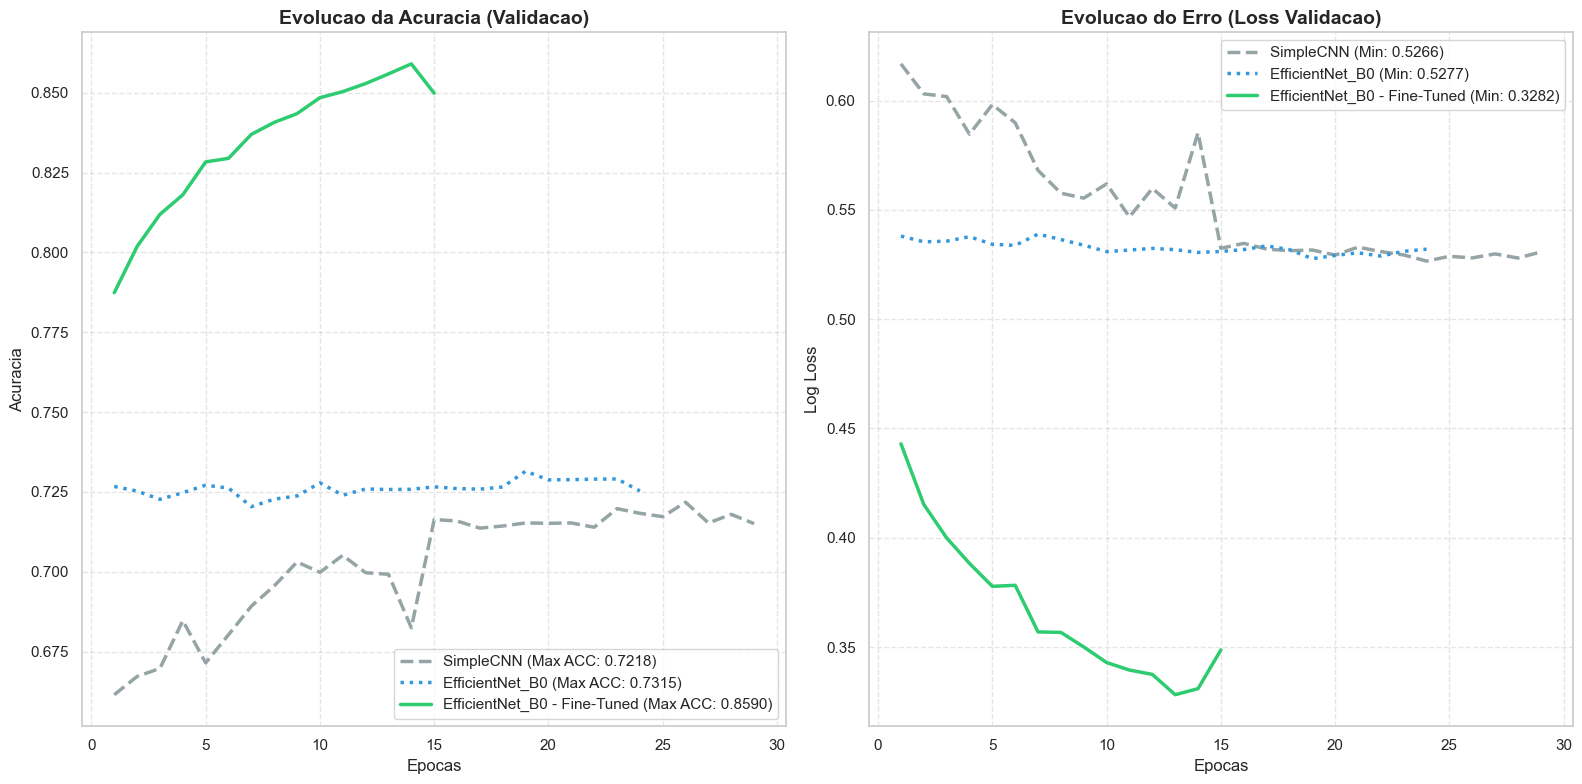

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams["figure.figsize"] = (16, 8)
sns.set_theme(style="whitegrid")

# funcao auxiliar para plotagem
def plot_comparison(histories, names):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    colors = ['#95a5a6', '#3498db', '#2ecc71'] 
    styles = ['--', ':', '-'] 
    
    # grafico 1: acuracia (validacao)
    for i, (h, name) in enumerate(zip(histories, names)):
        if h is None: continue
        
        acc = h.get('val_acc', h.get('acc', []))
        
        if len(acc) == 0: continue
        
        epochs = range(1, len(acc) + 1)
        best_val = max(acc)
        
        ax1.plot(epochs, acc, label=f'{name} (Max ACC: {best_val:.4f})', 
                 color=colors[i], linestyle=styles[i], linewidth=2.5)
    
    ax1.set_title("Evolucao da Acuracia (Validacao)", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Epocas")
    ax1.set_ylabel("Acuracia")
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # grafico 2: loss (validacao)
    for i, (h, name) in enumerate(zip(histories, names)):
        if h is None: continue
        loss = h.get('val_loss', h.get('loss', []))
        
        if len(loss) == 0: continue
        
        epochs = range(1, len(loss) + 1)
        min_loss = min(loss)
        
        ax2.plot(epochs, loss, label=f'{name} (Min: {min_loss:.4f})', 
                 color=colors[i], linestyle=styles[i], linewidth=2.5)
        
    ax2.set_title("Evolucao do Erro (Loss Validacao)", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Epocas")
    ax2.set_ylabel("Log Loss")
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# recuperacao dos historicos da memoria
hists = []
names = []

# 1. simple cnn
if 'simple_hist' in globals():
    hists.append(simple_hist)
    names.append("SimpleCNN")

# 2. efficientnet (fase 1)
if 'eff_hist' in globals():
    hists.append(eff_hist)
    names.append("EfficientNet_B0")

# 3. efficientnet fine-tuned (fase 2)
if 'ft_hist' in globals():
    hists.append(ft_hist)
    names.append("EfficientNet_B0 - Fine-Tuned")

if len(hists) > 0:
    print("Gerando graficos comparativos...")
    plot_comparison(hists, names)
else:
    print("Erro: Nenhum historico encontrado na memoria RAM.")

#### 6. Avaliacao Final com Teste, Metricas e Gráficos

In [ ]:
test_loader = DataLoader(
    test_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)
print("Loader de teste corrigido (Workers=0)!")

C:\Users\Desktop-Leo\AppData\Local\Temp\ipykernel_29888\514816687.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))



Avaliando: Simple CNN...
Pesos carregados: simple_cnn_best.pth


Inferencia: 100%|██████████| 175/175 [00:44<00:00,  3.90it/s]



Avaliando: EfficientNet-B0 (Final)...
Carregando pesos ImageNet...
Backbone congelado (Feature Extractor)
Pesos carregados: efficientnet_b0_finetuned.pth


Inferencia: 100%|██████████| 175/175 [00:49<00:00,  3.57it/s]

RELATORIO FINAL: Simple CNN
              precision    recall  f1-score   support

 Sem Garimpo     0.6922    0.8300    0.7549     11209
 Com Garimpo     0.7854    0.6275    0.6976     11109

    accuracy                         0.7292     22318
   macro avg     0.7388    0.7288    0.7262     22318
weighted avg     0.7386    0.7292    0.7264     22318

ROC-AUC Score: 0.8100


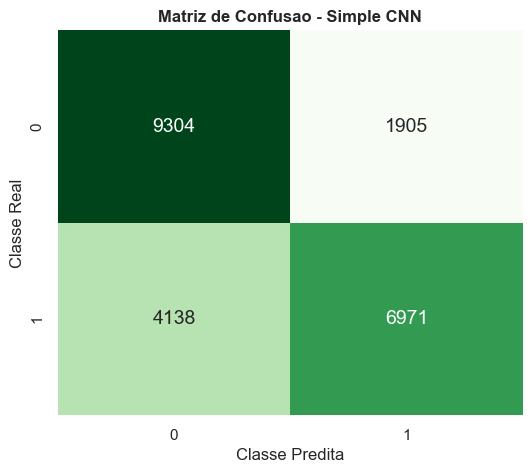

RELATORIO FINAL: EfficientNet-B0 (Final)
              precision    recall  f1-score   support

 Sem Garimpo     0.8625    0.8562    0.8593     11209
 Com Garimpo     0.8560    0.8623    0.8591     11109

    accuracy                         0.8592     22318
   macro avg     0.8592    0.8592    0.8592     22318
weighted avg     0.8592    0.8592    0.8592     22318

ROC-AUC Score: 0.9371


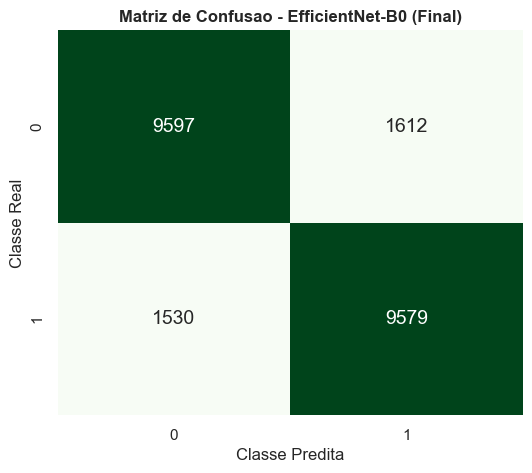


Tabela Comparativa Final
                    Modelo  Acuracia     AUC  F1-Score (Macro)  Precision  \
0               Simple CNN    0.7292  0.8100            0.7262     0.7388   
1  EfficientNet-B0 (Final)    0.8592  0.9371            0.8592     0.8592   

   Recall  
0  0.7288  
1  0.8592  


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
import seaborn as sns
import pandas as pd

# funcao de avaliacao no conjunto de teste
def evaluate_model(model_architecture, weights_path, loader, device, model_name):
    print(f"\nAvaliando: {model_name}...")
    
    # recria arquitetura limpa
    if 'Simple' in model_name:
        model = get_model('simple', device)
    else:
        model = get_model('efficientnet', device)
        
    # carrega pesos treinados
    try:
        model.load_state_dict(torch.load(weights_path))
        print(f"Pesos carregados: {weights_path}")
    except Exception as e:
        print(f"Erro ao carregar pesos: {e}")
        return None
        
    model.eval()
    
    y_true = []
    y_pred = []
    y_prob = []
    
    # loop de inferencia
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Inferencia"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            # probabilidades
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs[:, 1].cpu().numpy())
            
    return {
        'name': model_name,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

# execucao da avaliacao final
results_final = []

# 1. Simple CNN - baseline
res_simple = evaluate_model(SimpleCNN, "simple_cnn_best.pth", test_loader, DEVICE, "Simple CNN")
if res_simple: results_final.append(res_simple)

# 2. CNN com fine-tuned
res_eff = evaluate_model(TransferEfficientNet, "efficientnet_b0_finetuned.pth", test_loader, DEVICE, "EfficientNet-B0 (Final)")
if res_eff: results_final.append(res_eff)

# geracao de relatorios e graficos
for res in results_final:
    print(f"RELATORIO FINAL: {res['name']}")
    
    # metricas detalhadas
    print(classification_report(res['y_true'], res['y_pred'], target_names=['Sem Garimpo', 'Com Garimpo'], digits=4))
    
    # auc score
    auc = roc_auc_score(res['y_true'], res['y_prob'])
    print(f"ROC-AUC Score: {auc:.4f}")
    
    # matriz de confusao visual
    cm = confusion_matrix(res['y_true'], res['y_pred'])
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, annot_kws={"size": 14})
    plt.title(f"Matriz de Confusao - {res['name']}", fontsize=12, fontweight='bold')
    plt.ylabel("Classe Real")
    plt.xlabel("Classe Predita")
    plt.show()

print("\nTabela Comparativa Final")
summary = []
for res in results_final:
    p, r, f1, _ = precision_recall_fscore_support(res['y_true'], res['y_pred'], average='macro')
    auc = roc_auc_score(res['y_true'], res['y_prob'])
    acc = sum(np.array(res['y_true']) == np.array(res['y_pred'])) / len(res['y_true'])
    
    summary.append({
        "Modelo": res['name'],
        "Acuracia": acc,
        "AUC": auc,
        "F1-Score (Macro)": f1,
        "Precision": p,
        "Recall": r
    })

df_summary = pd.DataFrame(summary)
print(df_summary.round(4))

Gerando curvas comparativas...


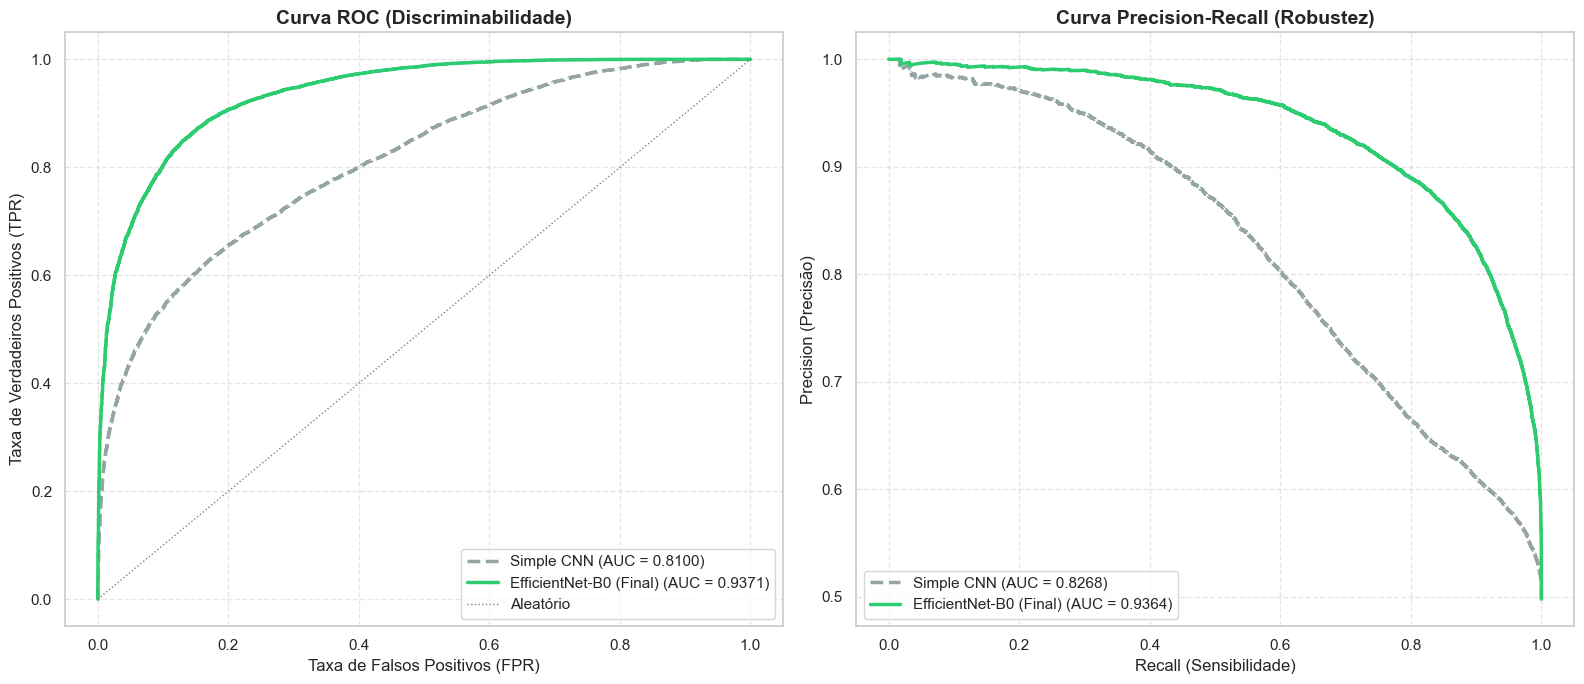

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

plt.rcParams["figure.figsize"] = (16, 7)
sns.set_theme(style="whitegrid")

def plot_final_curves(results_list):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    colors = ['#95a5a6', '#2ecc71'] 
    styles = ['--', '-'] 
    
    # grafico A: ROC Curve
    for i, res in enumerate(results_list):
        y_true = res['y_true']
        y_prob = res['y_prob']
        name = res['name']
        
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        
        ax1.plot(fpr, tpr, color=colors[i], linestyle=styles[i], lw=2.5, 
                 label=f'{name} (AUC = {roc_auc:.4f})')
    
    ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':', label='Aleatório')
    ax1.set_title("Curva ROC (Discriminabilidade)", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Taxa de Falsos Positivos (FPR)", fontsize=12)
    ax1.set_ylabel("Taxa de Verdadeiros Positivos (TPR)", fontsize=12)
    ax1.legend(loc="lower right", fontsize=11)
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # grafico B: Precision-Recall Curve
    for i, res in enumerate(results_list):
        y_true = res['y_true']
        y_prob = res['y_prob']
        name = res['name']
        
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall, precision)
        
        ax2.plot(recall, precision, color=colors[i], linestyle=styles[i], lw=2.5,
                 label=f'{name} (AUC = {pr_auc:.4f})')
        
    ax2.set_title("Curva Precision-Recall (Robustez)", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Recall (Sensibilidade)", fontsize=12)
    ax2.set_ylabel("Precision (Precisão)", fontsize=12)
    ax2.legend(loc="lower left", fontsize=11)
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

if 'results_final' in globals() and len(results_final) > 0:
    print("Gerando curvas comparativas...")
    plot_final_curves(results_final)
else:
    print("Erro: Variavel 'results_final' nao encontrada.")